# 1. Experiments with fail to control for the confounder

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖

## -Simulate a DGP

In [1]:
import pandas as pd
import numpy as np
import graphviz as gr

In [2]:
np.random.seed(24)
n = 100



hospital = np.random.binomial(1, 0.5, n)

medication = np.where(hospital.astype(bool),
                     np.random.binomial(1, 0.9, n),
                     np.random.binomial(1, 0.1, n))

severity = np.where(hospital.astype(bool), 
                    np.random.normal(5, 2, n),
                    np.random.normal(3, 2, n))

recovery = np.random.normal (2  + severity - medication) .astype(int)

hospital = pd.DataFrame(dict(hospital=hospital,
                             
                             medication=medication,
                             severity=severity,
                             recovery=recovery))

hospital.to_csv("Q2a_data.csv", index=False)

## -DAG

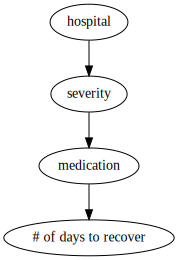

In [3]:
g = gr.Digraph()


g.edge("hospital", "severity")

g.edge("severity", "medication")
g.edge("medication", "# of days to recover")



g

## -Monte Carlo experiment

In [4]:
data = pd.read_csv("C:/Users/dell/Downloads/Q2a_data.csv")
data.head()

,hospital,medication,severity,recovery
0,1,1,2.589882,3
1,1,1,4.770640,4
2,1,1,3.941352,2
3,0,0,3.471656,6
4,0,0,0.827943,0


In [5]:
import statsmodels.formula.api as smf
model = smf.ols('recovery ~ hospital + medication + severity', data=data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.4403,0.244,5.910,0.000,0.957,1.924
hospital,-0.4808,0.325,-1.482,0.142,-1.125,0.163
medication,-0.6127,0.304,-2.014,0.047,-1.216,-0.009
severity,1.0041,0.055,18.158,0.000,0.894,1.114


In [6]:
print(data[["medication", "recovery"]].corr())

            medication  recovery
medication    1.000000 -0.005488
recovery     -0.005488  1.000000


In [7]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    hospital = np.random.binomial(1, 0.5, n)

    medication = np.where(hospital.astype(bool),
                         np.random.binomial(1, 0.9, n),
                         np.random.binomial(1, 0.1, n))

    severity = np.where(hospital.astype(bool), 
                        np.random.normal(5, 2, n),
                        np.random.normal(3, 2, n))

    Y = np.random.normal (2  + severity - medication) .astype(int)


#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

In [8]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [9]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    hospital = np.random.binomial(1, 0.5, n)

    T = np.where(hospital.astype(bool),
                         np.random.binomial(1, 0.9, n),
                         np.random.binomial(1, 0.1, n))

    severity = np.where(hospital.astype(bool), 
                        np.random.normal(5, 2, n),
                        np.random.normal(3, 2, n))

    Yab = np.random.normal (2  + severity - medication) .astype(int)

    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)]
            Yc = Yexp[np.where(T==0)]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [10]:
tau = -0.6
corr = 0.005
conf=False
p = 3
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:01<00:00, 336.50it/s]


In [11]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)]
        Yc = Yexp[np.where(T==0)]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:11<00:00, 170.75it/s]


In [12]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


N=100: bias=2.184188172808643, RMSE=2.2330331687220535, size=0.9955
N=1000: bias=2.224703562882925, RMSE=2.2753957433584477, size=0.9955


## -Real-life Example

How the medication will affect the recovery days whether the patient in hospital.